In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [4]:
sns.set()

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, silhouette_score
from sklearn.ensemble import RandomForestClassifier

## Data Prep

In [6]:
s_df = pd.read_csv('nba_offense.csv')
s_df['Player'] = s_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
s_df.shape

(2973, 74)

In [7]:
bbr_adv_df = pd.read_csv('bbr_nba_advanced_stats.csv')
bbr_adv_df.shape

(2986, 28)

In [8]:
bbr_ros_df = pd.read_csv('bbr_nba_roster_stats.csv')
bbr_ros_df.shape

(2988, 12)

In [9]:
bbr_df = bbr_adv_df.merge(bbr_ros_df, how='left',
                          on=['player', 'season', 'team', 'player_alt'])
bbr_df.shape

(2986, 36)

Convert Heights

In [10]:
def convert_height(height):
    feet, inches = height.split('-')
    cm = int(feet) * 12 + int(inches)
    return round(cm * 2.54, 1)

In [11]:
bbr_df['height_cm'] = bbr_df['height'].apply(convert_height)

Convert Weights

In [12]:
bbr_df['weight_kg'] = bbr_df['weight'].apply(lambda x: round(0.453592 * x, 1))

Filter in players with 200 shot possessions

In [13]:
s_df = s_df[s_df['Overall_Poss'] >= 200]
s_df.shape

(1785, 74)

Filter in players that played over 200 minutes

In [14]:
bbr_df = bbr_df[bbr_df['mp'] >= 200]
bbr_df.shape

(2268, 38)

Merge

In [15]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [16]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [17]:
bbr_df[bbr_df['player_alt_alt'].str.contains('lemon')]

,ranker,player,age,g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,...,pos,height,weight,birth_date,birth_country,years_experience,college,height_cm,weight_kg,player_alt_alt
1079,12,Chris Clemons,22,33,291,13.1,0.548,0.754,0.077,1.4,...,SG,5-9,180,"July 23, 1997",us,R,Campbell,175.3,81.6,chrisclemons


In [18]:
synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot'}
s_df['Player_Alt'] = s_df['Player_Alt'].apply(lambda x: synergy_name_dict[x] 
                                              if x in synergy_name_dict.keys()
                                              else x)

In [19]:
df = s_df.merge(bbr_df, how='left', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(1784, 114)

In [20]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(1784, 3)

## Functions

In [21]:
poss_ppp_cols = ['Spot Up_PPP', 'P&R Ball Handler_PPP', 'Transition_PPP',
                 'Cut_PPP', 'Offensive Rebounds (put backs)_PPP', 'Hand Off_PPP',
                 'P&R Roll Man_PPP', 'Isolation_PPP', 'Off Screen_PPP',
                 'Post-Up_PPP', 'Miscellaneous_PPP']

In [22]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 'Transition_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%', 'Hand Off_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 'Off Screen_Poss%',
                     'Post-Up_Poss%', 'Miscellaneous_Poss%']

In [23]:
def preprocess_data(x, scalers):
    for scaler in scalers:
        scaler.fit(x)
        x = scaler.transform(x)
    return x

In [24]:
def plot_elbow_plot(x, sample_weight=[]):   
    ssdist_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        km = KMeans(n_clusters=k, init='k-means++')
        if len(sample_weight) > 0:
            km.fit(x, sample_weight=sample_weight)
        else:
            km.fit(x)
        ssdist_list.append(km.inertia_)

    # Plot
    # Plot the elbow
    plt.plot(k_list, ssdist_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_sitances')
    plt.title('The Elbow Method showing the optimal k')

In [25]:
def plot_silhouette_score(x, sample_weight=[]):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        km = KMeans(n_clusters=k, init='k-means++')
        if len(sample_weight) > 0:
            cluster_labels = km.fit_predict(x, sample_weight=sample_weight)
        else:
            cluster_labels = km.fit_predict(x)
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method showing the optimal k')

In [26]:
def get_playtype_dist(df, poss_ppp_cols=poss_ppp_cols):
    playtype_dfs = []
    for col in poss_ppp_cols:
        playtype = col.replace('_PPP', '')
        playtype_df = pd.DataFrame()
        playtype_df['PPP'] = df[col]
        playtype_df['Poss%'] = df[f'{playtype}_Poss%'] * 100
        playtype_df['playtype'] = playtype
        playtype_dfs.append(playtype_df)   
    return pd.concat(playtype_dfs)

In [27]:
def show_cluster_res(df, cluster_col, poss_weights_cols=poss_weights_cols):
    cluster_res = df.groupby(cluster_col)[['usg_pct', 'obpm'] + poss_weights_cols]\
                .mean().sort_values('obpm', ascending=False)
    cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
    for col in cluster_res.columns:
        if '%' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    return cluster_res.T

In [28]:
def plot_cluster_res_2d(df, cluster_col, col1, col2):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, label=f'Cluster {cluster}', alpha=0.5)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [29]:
def check_cluster_robustness(x, k, n_iters, sample_weight=[]):
    cluster_res = []
    for i in range(n_iters):
        km = KMeans(n_clusters=k, init='k-means++')
        if len(sample_weight) > 0:
            km.fit_predict(x, sample_weight=sample_weight)
        else:
            km.fit_predict(x)
        pred = km.predict(x)
        res = sorted([list(pred).count(cluster) for cluster in list(range(k))])
        cluster_res.append('-'.join([str(n) for n in res]))
    return Counter(cluster_res)

In [30]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'obpm']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('obpm', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('obpm')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

## Clustering [Stage 1]

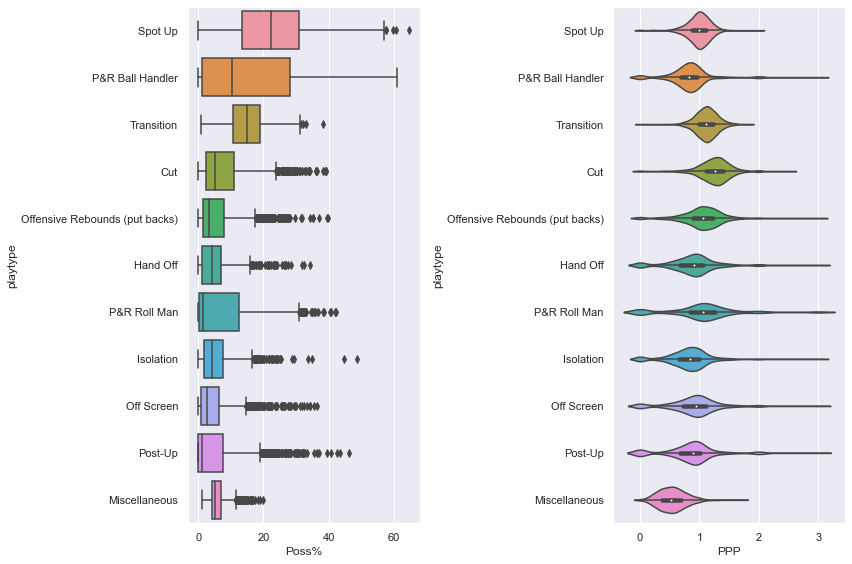

In [31]:
figsize(12, 8)
data = get_playtype_dist(df)
plt.subplot(1, 2, 1)
sns.boxplot(x="Poss%", y="playtype", data=data)
plt.subplot(1, 2, 2)
sns.violinplot(x="PPP", y="playtype", data=data)
plt.tight_layout()

Summary of distribution in playtype weights:
- Outliers exist 
    - Most of them are the result of skewed data
    - A few of them are creditted to players' own unique tendencies (ex. James Harden's iso game)
- There are some common playtypes
    - Spot Up
    - Transition
- Most are skewed
    - Big man
        - Cut
        - Offensive Rebounds
        - P&R Roll Man
        - Post-Up
    - Perimeter players
        - P&R Ball Handler
        - Hand Off
        - Off Screen
    - Star Privilege
        - Post-Up
        - Isolation
    
        

### Clustering

In [32]:
X = df[poss_weights_cols].copy()
X_transformed = preprocess_data(X, [PowerTransformer(), StandardScaler()])
poss_weights = df['usg_pct']

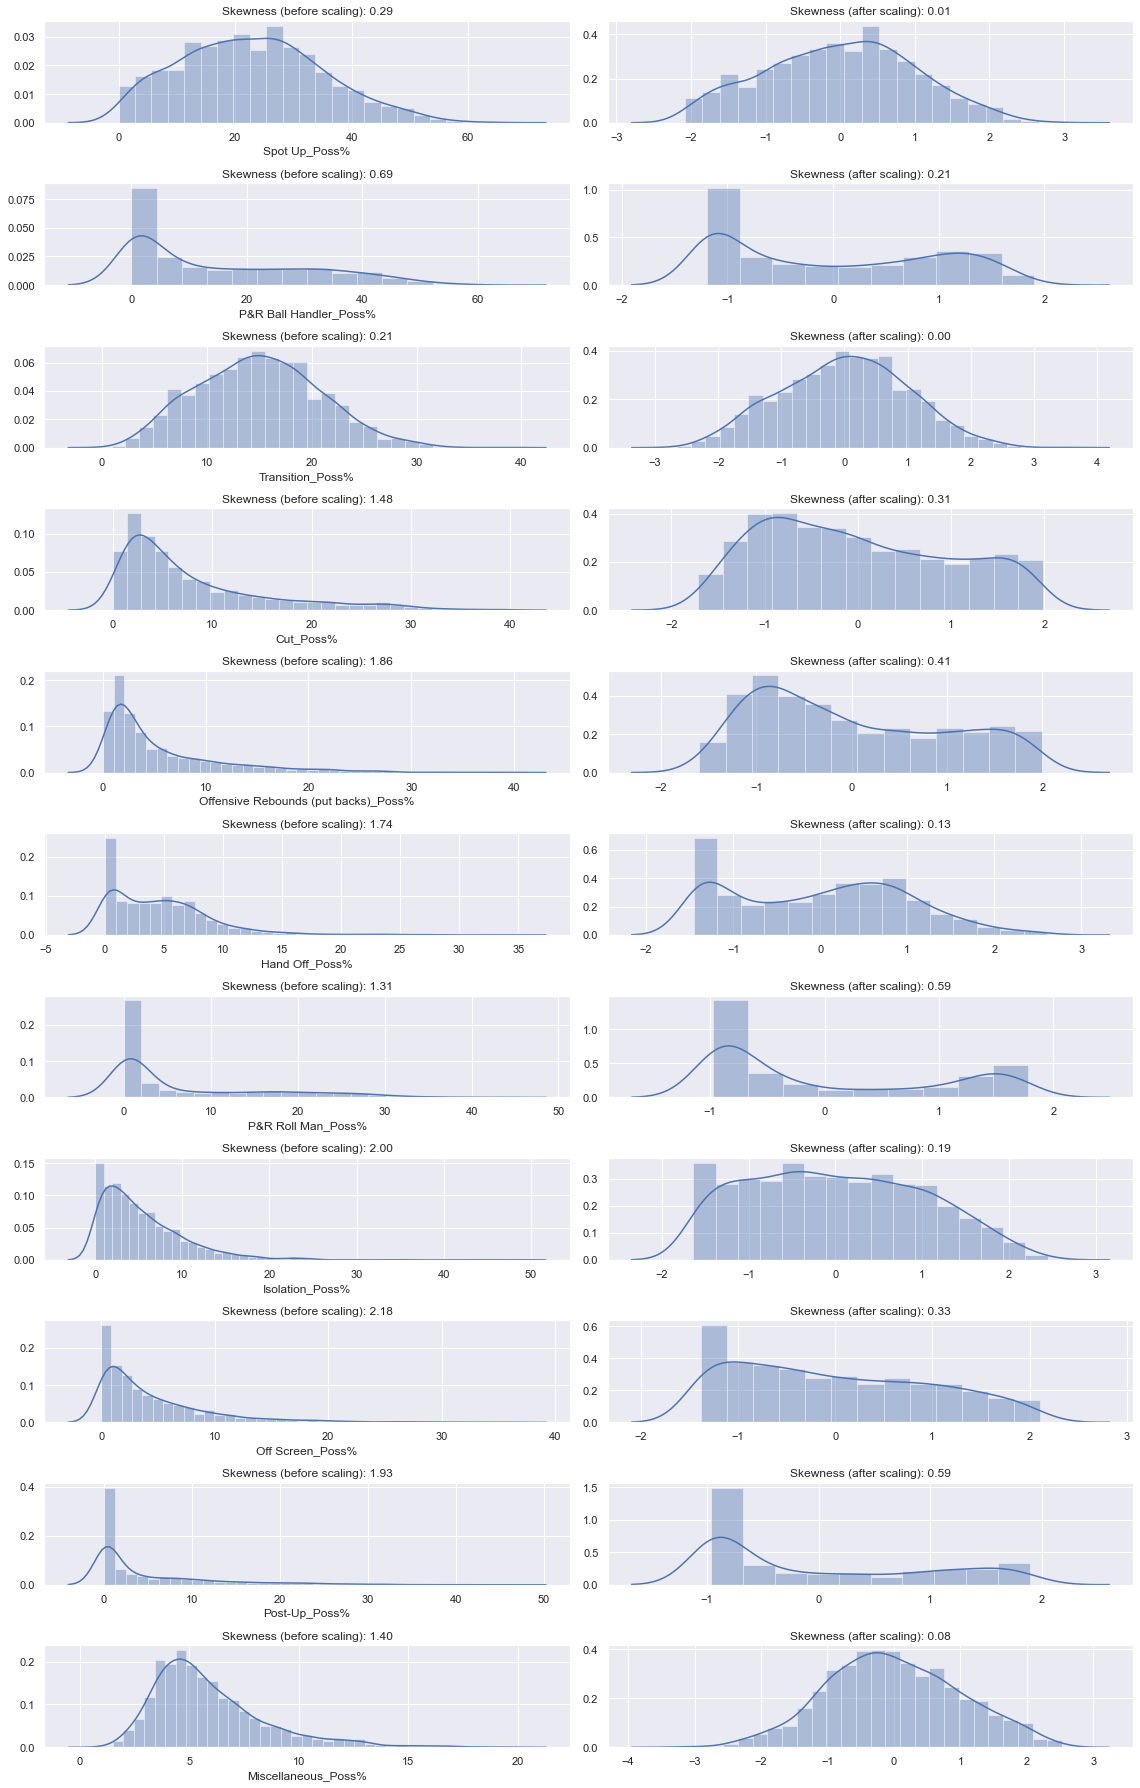

In [33]:
figsize(16, 25)
for i in range(11):
    plt.subplot(11, 2, i*2+1)
    sns.distplot(X[poss_weights_cols[i]] * 100)
    plt.title(f'Skewness (before scaling): {skew(X[poss_weights_cols[i]] * 100):.2f}')
    plt.subplot(11, 2, i*2+2)
    sns.distplot(X_transformed[:, i])
    plt.title(f'Skewness (after scaling): {skew(X_transformed[:, i]):.2f}')
plt.tight_layout()

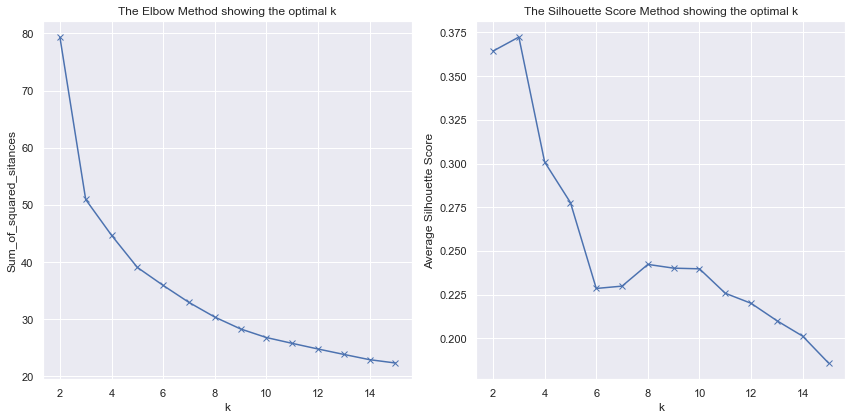

In [34]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plot_elbow_plot(X, sample_weight=poss_weights)
plt.subplot(1, 2, 2)
plot_silhouette_score(X, sample_weight=poss_weights)
plt.tight_layout()

The plot of silhouette score suggests k=3

In [35]:
# Check stability
check_cluster_robustness(X_transformed, 3, 300, sample_weight=poss_weights)

Counter({'538-613-633': 298, '538-614-632': 2})

Since K-means settles with local optima, try 1000 times to see if the clustering result stays robust. It turns out the algorithm delivers the same result 

### Results

In [36]:
# Choose k = 3
player_km_stage_1 = KMeans(n_clusters=3, init='k-means++', random_state=42)
player_km_stage_1.fit(X_transformed, sample_weight=poss_weights)
df['player_cluster_stage_1'] = player_km_stage_1.predict(X_transformed)
df.groupby('player_cluster_stage_1').count()['Player']

player_cluster_stage_1
0    613
1    538
2    633
Name: Player, dtype: int64

In [37]:
show_cluster_res(df, 'player_cluster_stage_1')

player_cluster_stage_1,0,1,2
usg_pct,22.9%,18.9%,17.1%
obpm,0.51,0.02,-1.19
Spot Up_Poss%,17.97%,15.64%,33.54%
P&R Ball Handler_Poss%,33.18%,0.95%,10.96%
Transition_Poss%,15.62%,9.70%,18.84%
Cut_Poss%,2.78%,16.23%,5.94%
Offensive Rebounds (put backs)_Poss%,1.81%,12.55%,3.69%
Hand Off_Poss%,6.05%,0.71%,7.03%
P&R Roll Man_Poss%,0.77%,19.22%,2.53%
Isolation_Poss%,9.76%,3.12%,3.22%


- Cluster 0 [613 Players]
    - Ballhandling role
        - P&R Ball Handler (High)
        - Isolation (High)
- Cluster 1 [538 Players]
    - Big Man role
        - P&R Roll Man (High)
        - Post-Up (High)
        - Miscellaneous (High)
        - Cut (High)
        - Offensive Reboudns (High)
- Cluster 2 [633 Players]
    - Wing role
        - Spot Up (High)
        - Transition (High)
        - Hand Off + Off Screen (High)

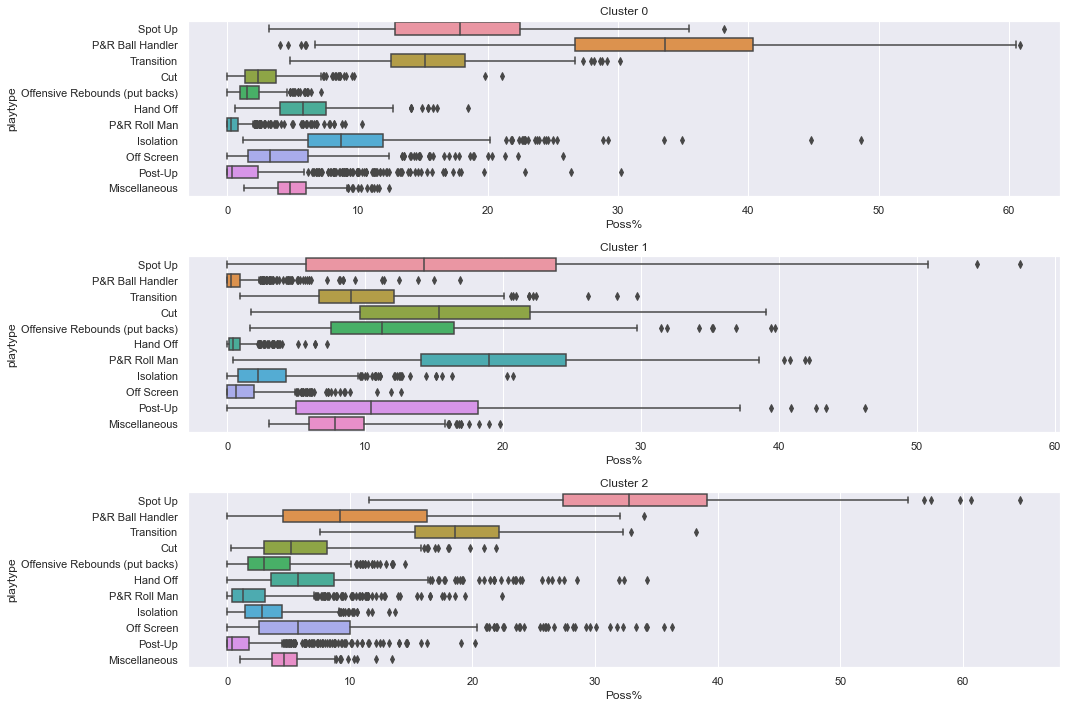

In [38]:
figsize(15, 10)
n_clusters = len(set(df['player_cluster_stage_1']))
data_dict = {cluster: get_playtype_dist(df[df['player_cluster_stage_1'] == cluster])
             for cluster in range(3)}

for cluster in range(3):
    data = get_playtype_dist(df[df['player_cluster_stage_1'] == cluster])
    plt.subplot(3, 1, cluster+1)
    sns.boxplot(x="Poss%", y="playtype", data=data_dict[cluster])
    plt.title(f'Cluster {cluster}')

plt.tight_layout()

Summary of distribution in playtype weights:
- Good:
    - Cluster separate playtypes regarding pick & roll nicely
    - Cluster separate iso & post-up nicely
- Bad:
    - Skewed data & Outliers still exist

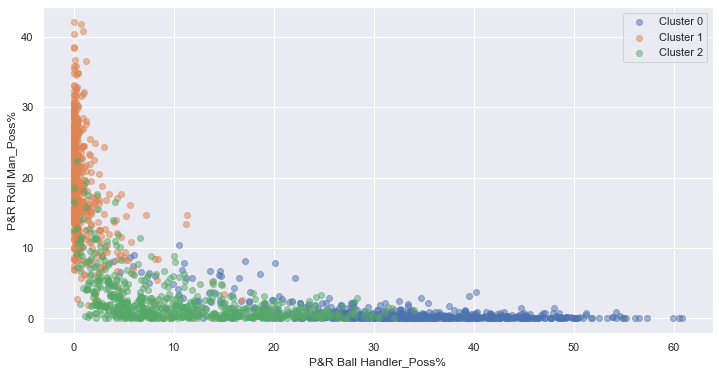

In [39]:
figsize(12, 6)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster_stage_1', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%')

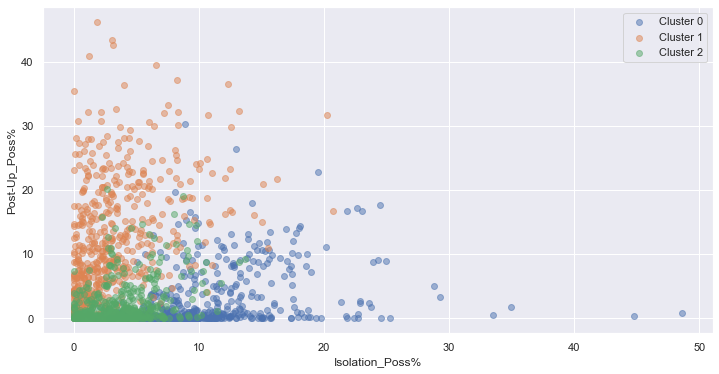

In [40]:
figsize(12, 6)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster_stage_1', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%')

In [41]:
temp = df.groupby('player')['player_cluster_stage_1'].apply(set).reset_index()
temp[temp['player_cluster_stage_1'].apply(len) == 3].player.values

array(['Aaron Gordon', 'Jerami Grant', 'Pascal Siakam', 'Rudy Gay'],
      dtype=object)

## Clustering [Stage 2]

In [42]:
df_0 = df[df['player_cluster_stage_1'] == 0].copy().reset_index().drop('index', axis=1)
df_1 = df[df['player_cluster_stage_1'] == 1].copy().reset_index().drop('index', axis=1)
df_2 = df[df['player_cluster_stage_1'] == 2].copy().reset_index().drop('index', axis=1)
print(f'0: {df_0.shape}')
print(f'1: {df_1.shape}')
print(f'2: {df_2.shape}')

0: (613, 115)
1: (538, 115)
2: (633, 115)


### Ballhandler

In [43]:
X_0 = df_0[poss_weights_cols]
X_0_transformed = preprocess_data(X_0, [PowerTransformer(), StandardScaler()])
poss_weights_0 = df_0['usg_pct']

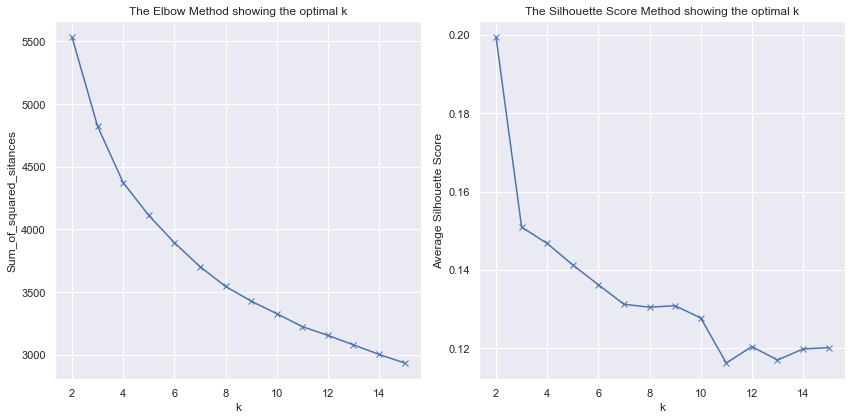

In [44]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plot_elbow_plot(X_0_transformed, sample_weight=poss_weights_0)
plt.subplot(1, 2, 2)
plot_silhouette_score(X_0_transformed, sample_weight=poss_weights_0)
plt.tight_layout()

In [45]:
# Check stability
check_cluster_robustness(X_0_transformed, 2, 300, sample_weight=poss_weights_0)

Counter({'177-436': 10,
         '173-440': 224,
         '178-435': 11,
         '181-432': 41,
         '176-437': 3,
         '179-434': 1,
         '175-438': 8,
         '180-433': 2})

In [46]:
# Choose k = 2
player_km_stage_2_0 = KMeans(n_clusters=2, init='k-means++', random_state=42)
player_km_stage_2_0.fit(X_0_transformed, sample_weight=poss_weights_0)
df_0['player_cluster_stage_2_0'] = player_km_stage_2_0.predict(X_0_transformed)
df_0.groupby('player_cluster_stage_2_0').count()['Player']

player_cluster_stage_2_0
0    173
1    440
Name: Player, dtype: int64

In [47]:
show_cluster_res(df_0, 'player_cluster_stage_2_0')

player_cluster_stage_2_0,0,1
usg_pct,25.3%,21.9%
obpm,1.82,-0.01
Spot Up_Poss%,16.50%,18.54%
P&R Ball Handler_Poss%,23.49%,36.99%
Transition_Poss%,15.33%,15.73%
Cut_Poss%,4.14%,2.25%
Offensive Rebounds (put backs)_Poss%,2.60%,1.50%
Hand Off_Poss%,5.49%,6.28%
P&R Roll Man_Poss%,1.96%,0.31%
Isolation_Poss%,12.37%,8.74%


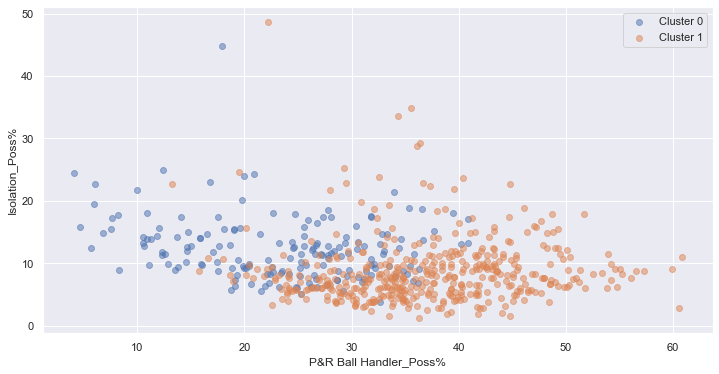

In [48]:
figsize(12, 6)
plot_cluster_res_2d(df_0, 
                    cluster_col='player_cluster_stage_2_0', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%')

In [49]:
display_cluster_players(df_0, 'player_cluster_stage_2_0', 0)

,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Russell Westbrook,2016,Oklahoma City Thunder,8.7,Rodney Hood,2020,Portland Trail Blazers,-5.3
1,James Harden,2019,Houston Rockets,8.1,Justise Winslow,2016,Miami Heat,-4.6
2,Stephen Curry,2017,Golden State Warriors,7.8,Jonathon Simmons,2018,Orlando Magic,-4.6
3,Giannis Antetokounmpo,2019,Milwaukee Bucks,7.4,Mario Hezonja,2018,New York Knicks,-3.5
4,LeBron James,2017,Cleveland Cavaliers,7.3,Brandon Ingram,2016,Los Angeles Lakers,-3.0
5,Stephen Curry,2018,Golden State Warriors,7.1,Shaun Livingston,2016,Golden State Warriors,-3.0
6,Kawhi Leonard,2016,San Antonio Spurs,7.1,Evan Turner,2017,Portland Trail Blazers,-2.9
7,Kevin Durant,2017,Golden State Warriors,6.7,RJ Barrett,2019,New York Knicks,-2.9
8,Stephen Curry,2016,Golden State Warriors,6.7,Shaun Livingston,2017,Golden State Warriors,-2.8
9,Kevin Durant,2016,Golden State Warriors,6.7,Dwyane Wade,2017,Miami Heat,-2.8


In [50]:
display_cluster_players(df_0, 'player_cluster_stage_2_0', 1)

,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,James Harden,2018,Houston Rockets,9.4,Killian Hayes,2020,Detroit Pistons,-6.3
1,James Harden,2017,Houston Rockets,8.5,Jawun Evans,2017,Los Angeles Clippers,-5.4
2,Stephen Curry,2020,Golden State Warriors,8.3,Malcom Delaney,2016,Atlanta Hawks,-5.3
3,Damian Lillard,2019,Portland Trail Blazers,8.3,Dennis Smith Jr.,2019,New York Knicks,-5.2
4,Isaiah Thomas,2016,Boston Celtics,7.8,Frank Ntilikina,2018,New York Knicks,-5.2
5,Damian Lillard,2020,Portland Trail Blazers,7.5,Chasson Randle,2020,Orlando Magic,-4.8
6,James Harden,2016,Houston Rockets,7.5,Dwayne Bacon,2017,Charlotte Hornets,-4.8
7,Luka Doncic,2019,Dallas Mavericks,7.4,Semaj Christon,2016,Oklahoma City Thunder,-4.8
8,Damian Lillard,2017,Portland Trail Blazers,7.0,Kobi Simmons,2017,Memphis Grizzlies,-4.7
9,Kyrie Irving,2019,Brooklyn Nets,6.7,Michael Carter-Williams,2020,Orlando Magic,-4.6


### Big Man

In [51]:
X_1 = df_1[poss_weights_cols]
X_1_transformed = preprocess_data(X_1, [PowerTransformer(), StandardScaler()])
poss_weights_1 = df_1['usg_pct']

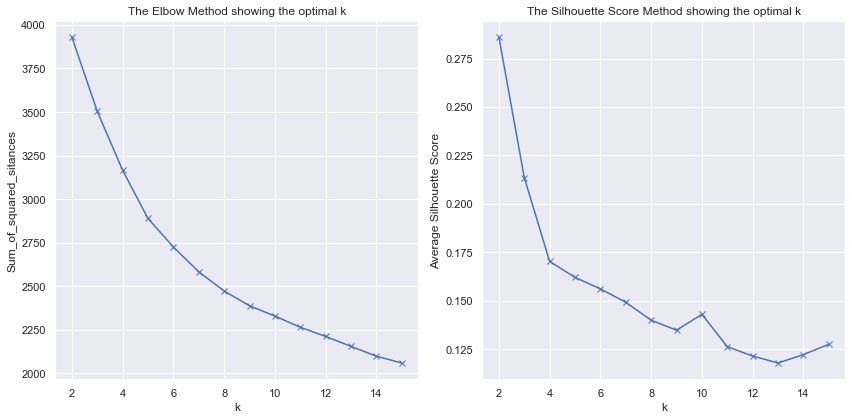

In [52]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plot_elbow_plot(X_1_transformed, sample_weight=poss_weights_1)
plt.subplot(1, 2, 2)
plot_silhouette_score(X_1_transformed, sample_weight=poss_weights_1)
plt.tight_layout()

In [53]:
# Check stability
check_cluster_robustness(X_1_transformed, 2, 300, sample_weight=poss_weights_1)

Counter({'246-292': 300})

In [54]:
# Choose k = 2
player_km_stage_2_1 = KMeans(n_clusters=2, init='k-means++', random_state=42)
player_km_stage_2_1.fit(X_1_transformed, sample_weight=poss_weights_1)
df_1['player_cluster_stage_2_1'] = player_km_stage_2_1.predict(X_1_transformed)
df_1.groupby('player_cluster_stage_2_1').count()['Player']

player_cluster_stage_2_1
0    292
1    246
Name: Player, dtype: int64

In [55]:
show_cluster_res(df_1, 'player_cluster_stage_2_1')

player_cluster_stage_2_1,1,0
usg_pct,20.7%,17.4%
obpm,0.50,-0.39
Spot Up_Poss%,24.00%,8.60%
P&R Ball Handler_Poss%,1.82%,0.22%
Transition_Poss%,11.66%,8.05%
Cut_Poss%,9.99%,21.48%
Offensive Rebounds (put backs)_Poss%,7.71%,16.63%
Hand Off_Poss%,1.26%,0.25%
P&R Roll Man_Poss%,15.66%,22.22%
Isolation_Poss%,4.48%,1.97%


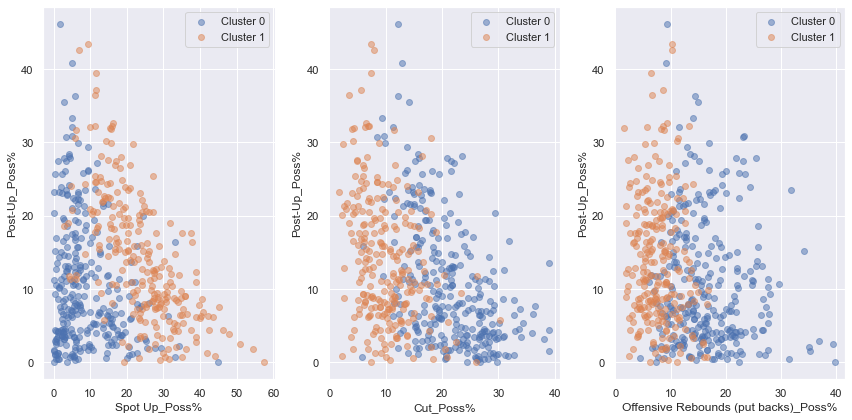

In [56]:
figsize(12, 6)
for idx, col in enumerate(['Spot Up', 'Cut', 'Offensive Rebounds (put backs)'], 1):
    plt.subplot(1, 3, idx)
    plot_cluster_res_2d(df_1, 
                        cluster_col='player_cluster_stage_2_1', 
                        col1=f'{col}_Poss%', 
                        col2='Post-Up_Poss%')
plt.tight_layout()

In [57]:
display_cluster_players(df_1, 'player_cluster_stage_2_1', 0)

,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Clint Capela,2018,Houston Rockets,3.3,Dewayne Dedmon,2019,Sacramento Kings,-6.3
1,Enes Kanter,2017,New York Knicks,3.3,Ian Mahinmi,2017,Washington Wizards,-4.6
2,Jonas Valanciunas,2020,Memphis Grizzlies,3.2,Zach Collins,2017,Portland Trail Blazers,-4.5
3,Enes Kanter,2016,Oklahoma City Thunder,3.0,Alexis Ajinca,2016,New Orleans Pelicans,-4.0
4,Rudy Gobert,2018,Utah Jazz,3.0,Miles Plumlee,2017,Atlanta Hawks,-3.7
5,Robert Williams III,2020,Boston Celtics,2.9,Precious Achiuwa,2020,Miami Heat,-3.6
6,Thomas Bryant,2019,Washington Wizards,2.9,Aron Baynes,2017,Boston Celtics,-3.6
7,Boban Marjanovic,2019,Dallas Mavericks,2.8,Greg Monroe,2018,Toronto Raptors,-3.5
8,Clint Capela,2020,Atlanta Hawks,2.7,Harry Giles,2018,Sacramento Kings,-3.4
9,Montrezl Harrell,2018,Los Angeles Clippers,2.6,Bismack Biyombo,2020,Charlotte Hornets,-3.4


In [58]:
display_cluster_players(df_1, 'player_cluster_stage_2_1', 1)

,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Nikola Jokic,2020,Denver Nuggets,9.1,Jarell Martin,2016,Memphis Grizzlies,-5.3
1,Anthony Davis,2018,New Orleans Pelicans,7.1,Domantas Sabonis,2016,Oklahoma City Thunder,-4.5
2,Karl-Anthony Towns,2019,Minnesota Timberwolves,7.0,Grant Williams,2019,Boston Celtics,-4.1
3,Joel Embiid,2020,Philadelphia 76ers,6.3,James Wiseman,2020,Golden State Warriors,-4.0
4,Nikola Jokic,2018,Denver Nuggets,6.2,Grant Williams,2020,Boston Celtics,-4.0
5,Zion Williamson,2020,New Orleans Pelicans,6.1,Moritz Wagner,2018,Los Angeles Lakers,-3.9
6,Nikola Jokic,2016,Denver Nuggets,5.9,Isaiah Roby,2020,Oklahoma City Thunder,-3.7
7,DeMarcus Cousins,2016,Sacramento Kings,5.6,Dragan Bender,2018,Phoenix Suns,-3.4
8,Karl-Anthony Towns,2016,Minnesota Timberwolves,5.5,Jarell Martin,2017,Memphis Grizzlies,-3.3
9,Nikola Vucevic,2020,Orlando Magic,5.5,Marquese Chriss,2017,Phoenix Suns,-3.2


### Wing

In [59]:
X_2 = df_2[poss_weights_cols]
X_2_transformed = preprocess_data(X_2, [PowerTransformer(), StandardScaler()])
poss_weights_2 = df_2['usg_pct']

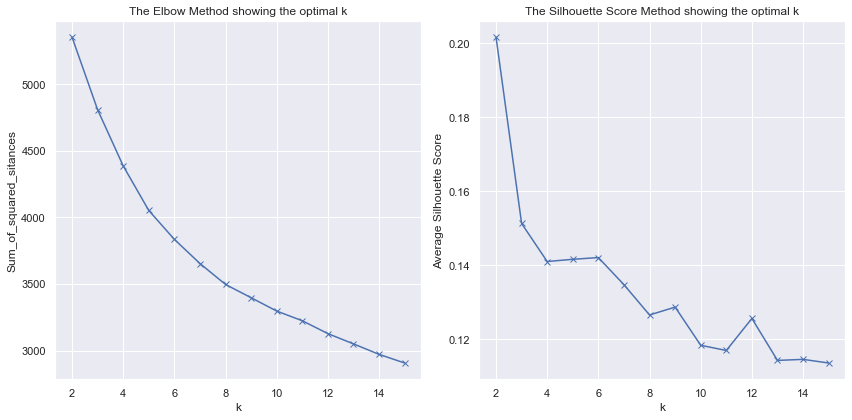

In [60]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plot_elbow_plot(X_2_transformed, sample_weight=poss_weights_2)
plt.subplot(1, 2, 2)
plot_silhouette_score(X_2_transformed, sample_weight=poss_weights_2)
plt.tight_layout()

In [61]:
# Check stability
check_cluster_robustness(X_2_transformed, 2, 300, sample_weight=poss_weights_2)

Counter({'298-335': 300})

In [62]:
# Choose k = 2
player_km_stage_2_2 = KMeans(n_clusters=2, init='k-means++', random_state=42)
player_km_stage_2_2.fit(X_2_transformed, sample_weight=poss_weights_2)
df_2['player_cluster_stage_2_2'] = player_km_stage_2_2.predict(X_2_transformed)
df_2.groupby('player_cluster_stage_2_2').count()['Player']

player_cluster_stage_2_2
0    298
1    335
Name: Player, dtype: int64

In [63]:
show_cluster_res(df_2, 'player_cluster_stage_2_2')

player_cluster_stage_2_2,1,0
usg_pct,18.1%,15.9%
obpm,-1.05,-1.34
Spot Up_Poss%,30.53%,36.92%
P&R Ball Handler_Poss%,14.66%,6.81%
Transition_Poss%,18.55%,19.17%
Cut_Poss%,4.26%,7.84%
Offensive Rebounds (put backs)_Poss%,2.08%,5.49%
Hand Off_Poss%,9.76%,3.97%
P&R Roll Man_Poss%,1.05%,4.19%
Isolation_Poss%,3.05%,3.42%


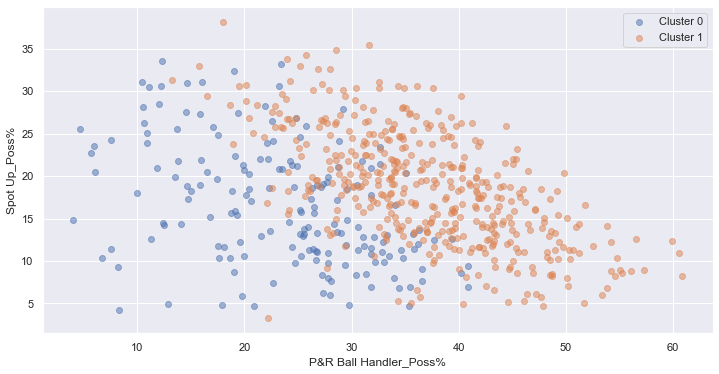

In [64]:
figsize(12, 6)
plot_cluster_res_2d(df_0, 
                    cluster_col='player_cluster_stage_2_0', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%')

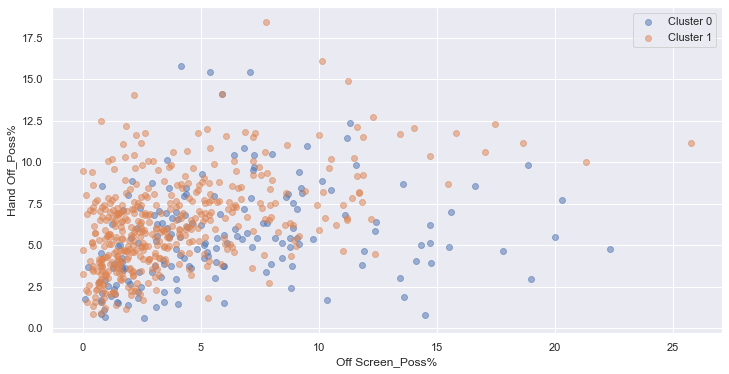

In [65]:
figsize(12, 6)
plot_cluster_res_2d(df_0, 
                    cluster_col='player_cluster_stage_2_0', 
                    col1='Off Screen_Poss%', 
                    col2='Hand Off_Poss%')

In [66]:
display_cluster_players(df_2, 'player_cluster_stage_2_2', 0)

,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Michael Porter Jr.,2020,Denver Nuggets,4.0,Justise Winslow,2020,Memphis Grizzlies,-6.2
1,Otto Porter Jr.,2017,Washington Wizards,2.6,Tyrone Wallace,2018,Los Angeles Clippers,-5.6
2,Mikal Bridges,2020,Phoenix Suns,2.4,Paul Zipser,2017,Chicago Bulls,-5.5
3,Michael Porter Jr.,2019,Denver Nuggets,2.4,Sekou Doumbouya,2020,Detroit Pistons,-5.4
4,Otto Porter Jr.,2016,Washington Wizards,2.4,Sekou Doumbouya,2019,Detroit Pistons,-5.2
5,Nikola Mirotic,2018,New Orleans Pelicans,2.3,Treveon Graham,2019,Minnesota Timberwolves,-5.0
6,Jabari Parker,2016,Milwaukee Bucks,2.1,Lance Thomas,2018,New York Knicks,-4.8
7,Dario Saric,2017,Philadelphia 76ers,1.8,Terrance Ferguson,2019,Oklahoma City Thunder,-4.8
8,Ryan Anderson,2016,Houston Rockets,1.7,Corey Brewer,2017,Los Angeles Lakers,-4.7
9,Danilo Gallinari,2020,Atlanta Hawks,1.7,Semi Ojeleye,2017,Boston Celtics,-4.6


In [67]:
display_cluster_players(df_2, 'player_cluster_stage_2_2', 1)

,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Buddy Hield,2018,Sacramento Kings,3.5,Dwayne Bacon,2019,Charlotte Hornets,-5.9
1,Bogdan Bogdanovic,2020,Atlanta Hawks,3.3,Abdel Nader,2017,Boston Celtics,-5.5
2,Jaylen Brown,2020,Boston Celtics,3.2,Aleksej Pokusevski,2020,Oklahoma City Thunder,-5.1
3,Davis Bertans,2019,Washington Wizards,2.7,Gabe Vincent,2020,Miami Heat,-4.5
4,Klay Thompson,2016,Golden State Warriors,2.4,Brad Wanamaker,2020,Golden State Warriors,-4.4
5,JJ Redick,2019,New Orleans Pelicans,2.3,Stanley Johnson,2016,Detroit Pistons,-4.4
6,JJ Redick,2017,Philadelphia 76ers,2.2,Patrick McCaw,2017,Golden State Warriors,-4.3
7,Norman Powell,2020,Toronto Raptors,2.2,Paul Zipser,2016,Chicago Bulls,-4.2
8,Tobias Harris,2017,Detroit Pistons,2.2,Grayson Allen,2018,Utah Jazz,-4.2
9,JJ Redick,2018,Philadelphia 76ers,2.2,Mario Hezonja,2016,Orlando Magic,-4.1


In [124]:
def adj_df(df, cluster_col, pos):
    return show_cluster_res(df, cluster_col).rename(columns={l: f'{pos}_{l}' for l in range(2)})
                                            
temp = pd.concat([adj_df(df_0, 'player_cluster_stage_2_0', 'ballhandler').T,
           adj_df(df_1, 'player_cluster_stage_2_1', 'big').T,
           adj_df(df_2, 'player_cluster_stage_2_2', 'wing').T])
temp['obpm'] = temp['obpm'].apply(float)
temp = temp.sort_values('obpm', ascending=False)
temp['obpm'] = temp['obpm'].apply(lambda x: f'{x:.2f}')
temp.T

,ballhandler_0,big_1,ballhandler_1,big_0,wing_1,wing_0
usg_pct,25.3%,20.7%,21.9%,17.4%,18.1%,15.9%
obpm,1.82,0.50,-0.01,-0.39,-1.05,-1.34
Spot Up_Poss%,16.50%,24.00%,18.54%,8.60%,30.53%,36.92%
P&R Ball Handler_Poss%,23.49%,1.82%,36.99%,0.22%,14.66%,6.81%
Transition_Poss%,15.33%,11.66%,15.73%,8.05%,18.55%,19.17%
Cut_Poss%,4.14%,9.99%,2.25%,21.48%,4.26%,7.84%
Offensive Rebounds (put backs)_Poss%,2.60%,7.71%,1.50%,16.63%,2.08%,5.49%
Hand Off_Poss%,5.49%,1.26%,6.28%,0.25%,9.76%,3.97%
P&R Roll Man_Poss%,1.96%,15.66%,0.31%,22.22%,1.05%,4.19%
Isolation_Poss%,12.37%,4.48%,8.74%,1.97%,3.05%,3.42%
